In [1]:
# Load libraries
import openpyxl
import Levenshtein
from fuzzywuzzy import fuzz
import string
import re
import nltk
import itertools
from nltk.tokenize import sent_tokenize
from collections import defaultdict

In [3]:
# Specify the path to your Excel file
# excel_file_path = "Assignment1GoldStandardSet.xlsx"
excel_file_path = "UnlabeledSet.xlsx"

# Load the Excel workbook
workbook = openpyxl.load_workbook(excel_file_path, read_only=True, data_only=True)

# Access a specific sheet by name
sheet = workbook.active

# Read all the reddit posts
texts = []
for i in range(2, 402): 
#     col = 'B' # change C to B for golden standard
    col = 'C'
    if sheet[col+str(i)].value == None:
        continue
    text = sheet[col+str(i)].value 
    texts.append(text.lower()) 

In [4]:
# Read Sympthom Lexicon files
lexicon_dict = {}
symptom_dict = {}
infile = open('./COVID-Twitter-Symptom-Lexicon.txt')
for line in infile:
    items = line.split('\t')
    # Build lexicon dictionary
    if items[1] in lexicon_dict:
        lexicon_dict[items[1]].append(items[-1].strip().lower()) # strip for \n at the end of lexicon/ lowercase
    else: 
        lexicon_dict[items[1]] = [items[-1].strip().lower()] # strip for \n at the end of lexicon/ lowercase
    
    # Build Symptom dictionary
    if not items[1] in symptom_dict:
        symptom_dict[items[1]] = items[0]

In [106]:
n = 15

text = texts[n]
print(len(texts))
text

35


'i tested positive in march, was really sick, much better now, ( still have rash and fatigue) but does anyone else (who tested positive please) feel hot water drastically more than they used to? i have my showers on tepid now because the temps i used to use feel like they are burning my skin.'

In [107]:
for CUI in lexicon_dict.keys():
    mt = match_dict_similarity(texts[n], CUI)
    if mt == None:
        continue
    print(mt)
    is_negated = False
    #Note: I broke down the code into simpler chunks for easier understanding..
    text = mt[0]
    cui = mt[1]
    expression = mt[2]
    start = mt[3]
    end = mt[4]
    #uncomment the print calls to separate each text fragment..
    #print('=------=')

    #go through each negation expression
    for neg in negations:
        #check if the negation matches anything in the text of the tuple
        for match in re.finditer(r'\b'+neg+r'\b', text):
            #if there is a negation in the sentence, we need to check
            #if the symptom expression also falls under this expression
            #it's perhaps best to pass this functionality to a function.
            # See the in_scope() function
            is_negated = in_scope(match.end(),text,expression)
            if is_negated:
                cui += 'neg'
                print('------------------')
                print(cui)
                mt[1] = cui
                break

0.9354838709677419   lungs feel like they are burning use feel like they are burning C0008031
0.8524590163934426   lungs feel like they are burning feel like they are burning my C0008031
['i have my showers on tepid now because the temps i used to use feel like they are burning my skin.', 'C0008031', 'use feel like they are burning', 'lungs feel like they are burning', 59, 89]
1.0                  fatigue              fatigue                   C0015672
0.9333333333333333   fatigued             fatigue                   C0015672
['i tested positive in march, was really sick, much better now, ( still have rash and fatigue) but does anyone else (who tested positive please) feel hot water drastically more than they used to?', 'C0015672', 'fatigue', 'fatigue', 84, 91]
1.0                  rash                 rash                      C0015230
['i tested positive in march, was really sick, much better now, ( still have rash and fatigue) but does anyone else (who tested positive please) feel

In [5]:
def run_sliding_window_through_text(words, window_size):
    """
    Generate a window sliding through a sequence of words
    """
    word_iterator = iter(words) # creates an object which can be iterated one element at a time
    word_window = tuple(itertools.islice(word_iterator, window_size)) #islice() makes an iterator that returns selected elements from the the word_iterator
    yield word_window
    #now to move the window forward, one word at a time
    for w in word_iterator:
        word_window = word_window[1:] + (w,)
        yield word_window

In [8]:
def match_dict_similarity(text, CUI):
    match_list = None
    max_similarity_obtained = -1
    best_match = ''
    words = list(nltk.word_tokenize(text))
    sents = list(nltk.sent_tokenize(text))
    #go through each expression
    expressions = lexicon_dict[CUI]
    for exp in expressions:
        #create the window size equal to the number of word in the expression in the lexicon
        size_of_window = len(exp.split())
        thr = max(1 - 0.07 * len(exp.split()), 0.8)
#         thr = 0.75
        for window in run_sliding_window_through_text(words, size_of_window):
            window_string = ' '.join(window)

            
            similarity_score = Levenshtein.ratio(window_string, exp)
            
            if similarity_score >= thr:

#                 print("{:<20} {:<20} {:<25} {:<8}".format(similarity_score, exp, window_string, CUI))
                if similarity_score>max_similarity_obtained:
                    max_similarity_obtained = similarity_score
                    best_match = window_string
                    best_sent = ''
                    pattern = re.escape(window_string)
                    for sent in sents:
                        for match in re.finditer(pattern, sent):
                            match_list = [sent, CUI, window_string, exp, match.start(), match.end()]
        
    return match_list 

In [9]:
text_symptom_dict = {}
i = 0
for text in texts:
    text_symptom_dict[i] = []
    print(i)
    for CUI in lexicon_dict.keys():
        match_list = match_dict_similarity(text, CUI)
        if not match_list == None:
            text_symptom_dict[i].append(match_list)
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
def in_scope(neg_end, text,symptom_expression):
    '''
    Function to check if a symptom occurs within the scope of a negation based on some
    pre-defined rules.
    :param neg_end: the end index of the negation expression
    :param text:
    :param symptom_expression:
    :return:
    '''
    negated = False
    text_following_negation = text[neg_end:]
    tokenized_text_following_negation = list(nltk.word_tokenize(text_following_negation))
    # this is the maximum scope of the negation, unless there is a '.' or another negation
    three_terms_following_negation = ' '.join(tokenized_text_following_negation[:min(len(tokenized_text_following_negation),4)])
    #Note: in the above we have to make sure that the text actually contains 3 words after the negation
    #that's why we are using the min function -- it will be the minimum or 3 or whatever number of terms are occurring after
    #the negation. Uncomment the print function to see these texts.
    #print (three_terms_following_negation)
    match_object = re.search(symptom_expression,three_terms_following_negation)
    if match_object:
        period_check = re.search('\.',three_terms_following_negation)
        next_negation = 1000 #starting with a very large number
        #searching for more negations that may be occurring
        for neg in negations:
            # a little simplified search..
            if re.search(neg,text_following_negation):
                index = text_following_negation.find(neg)
                if index<next_negation:
                    next_negation = index
        if period_check:
            #if the period occurs after the symptom expression
            if period_check.start() > match_object.start() and next_negation > match_object.start():
                negated = True
        else:
            negated = True
    return negated

In [11]:
#loading the negation expressions
negations = []
infile = open('./neg_trigs.txt')
for line in infile:
    negations.append(str.strip(line))

In [12]:
for i in range(len(text_symptom_dict)):
    for mt in text_symptom_dict[i]:
        is_negated = False
        #Note: I broke down the code into simpler chunks for easier understanding..
        text = mt[0]
        cui = mt[1]
        expression = mt[2]
        start = mt[3]
        end = mt[4]
        #uncomment the print calls to separate each text fragment..
        #print('=------=')

        #go through each negation expression
        for neg in negations:
            #check if the negation matches anything in the text of the tuple
            for match in re.finditer(r'\b'+neg+r'\b', text):
                #if there is a negation in the sentence, we need to check
                #if the symptom expression also falls under this expression
                #it's perhaps best to pass this functionality to a function.
                # See the in_scope() function
                is_negated = in_scope(match.end(),text,expression)
                if is_negated:
                    cui += 'neg'
                    mt[1] = cui
                    break

In [13]:
file_dict = {}
for i in range(len(text_symptom_dict)):
    symptom_exps = '$$$'
    std_symptom = '$$$'
    symptom_CUIs = '$$$'
    neg_flag = '$$$'
    for j in range(len(text_symptom_dict[i])):
        symptom_exps += (text_symptom_dict[i][j][2] + '$$$')
        CUI = text_symptom_dict[i][j][1][:8]
        std_symptom += (symptom_dict[CUI] + '$$$')
        symptom_CUIs += (CUI + '$$$')
        if text_symptom_dict[i][j][1].endswith('neg'):
            neg_flag += '1$$$'
        else:
            neg_flag += '0$$$'
    file_dict[i] = [symptom_exps, std_symptom, symptom_CUIs, neg_flag]

In [14]:
file_path = 'UnlabeledSetResult.xlsx' # change the file name you wish
# Load the existing Excel workbook
workbook = openpyxl.load_workbook(file_path)
# Choose a specific sheet to work with (if it exists)
sheet = workbook.active  # This selects the default active sheet
for i in range(len(file_dict)):
    sheet['D'+str(i+2)] = file_dict[i][0]
    sheet['E'+str(i+2)] = file_dict[i][1]
    sheet['F'+str(i+2)] = file_dict[i][2]
    sheet['G'+str(i+2)] = file_dict[i][3]
    
workbook.save(file_path)

In [15]:
cui_lexicon_dict = defaultdict(int)
for i in range(len(file_dict)):
    CUI = file_dict[i][2].split('$$$')
    CUI = [cui for cui in CUI if not cui == '']
    for cui in CUI:
        cui_lexicon_dict[symptom_dict[cui]] += 1

In [16]:
cui_lexicon_dict

defaultdict(int,
            {'Anxiety, stress & general mental health symptoms': 95,
             'Chest tightness': 77,
             'Headache': 100,
             'Rhinorrhea': 38,
             'Chest pain': 103,
             'Cough': 200,
             'Dyspnea': 179,
             'Oropharyngeal pain': 80,
             'Pyrexia': 235,
             'Ageusia': 95,
             'Vomiting': 23,
             'Body ache & Pain': 143,
             'Fatigue': 169,
             'Myalgia': 37,
             'Diarrhea/GI issues': 72,
             'Chills': 59,
             'Hyperhidrosis': 39,
             'Anosmia': 79,
             'Eye pain': 23,
             'Insomnia/sleep disturbance': 15,
             'Lethargic': 12,
             'Hypertension': 21,
             'Bronchitis': 14,
             'Migraine': 7,
             'Dizziness/disorientation/confusion': 41,
             'Loss of appetite': 32,
             'Rash': 6,
             'Dehydration': 8,
             'Nausea': 39,
         

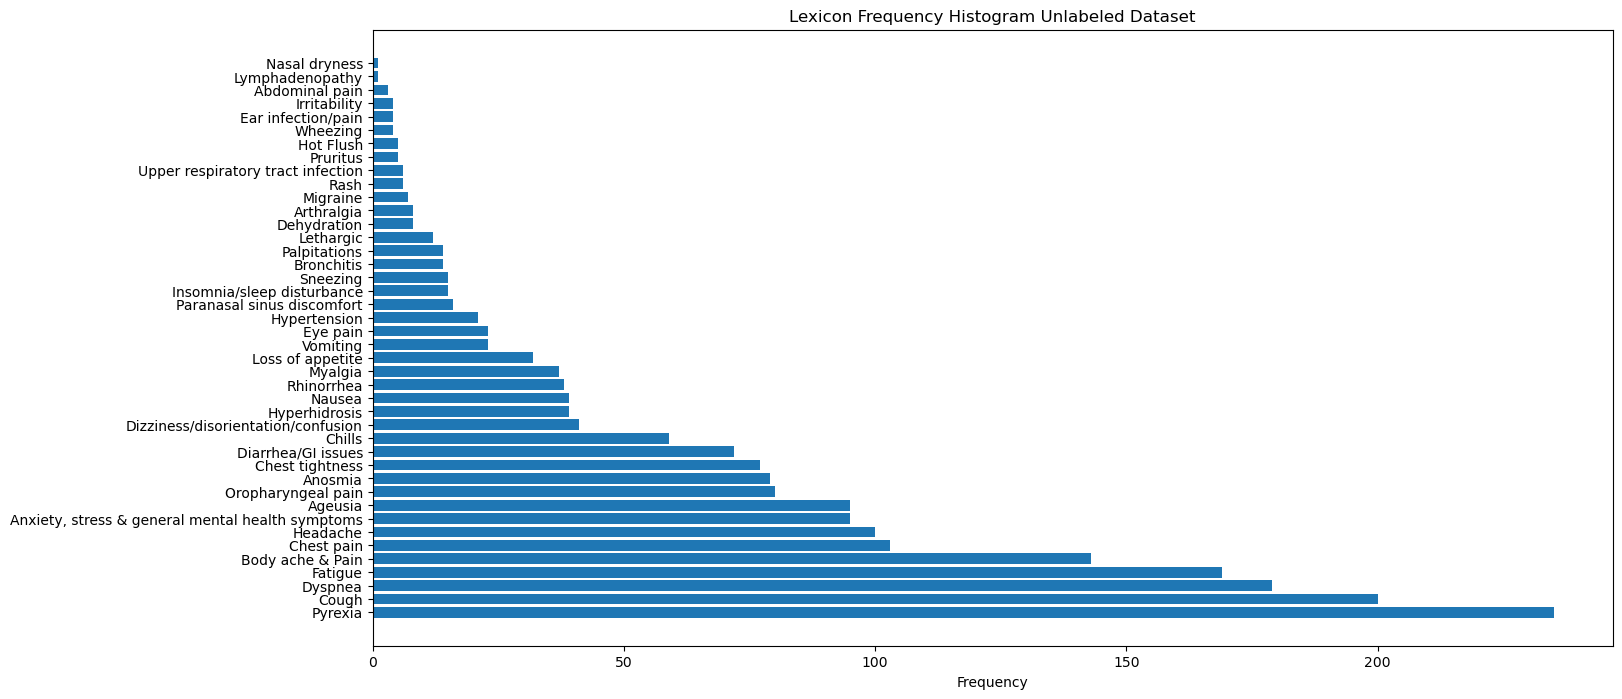

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 8))
# Sort the dictionary by values in descending order
sorted_data = dict(sorted(cui_lexicon_dict.items(), key=lambda item: item[1], reverse=True))

# Extract values (frequencies) from the dictionary
frequencies = list(sorted_data.values())
labels = list(sorted_data.keys())

# Create a horizontal bar chart
plt.barh(labels, frequencies)  # Use barh for horizontal bars

# Add labels and title
plt.xlabel('Frequency')
plt.title('Lexicon Frequency Histogram Unlabeled Dataset')

# Show the plot
plt.show()